In [16]:
from math import cos, exp, pi, tanh, sqrt
from scipy.integrate import quad, dblquad
from scipy.misc import derivative
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
from matplotlib.pyplot import figure
from scipy import optimize

In [2]:
def phi(x):
    #we choose what our activation function is going to be here
    return tanh(x)

def normDist(z):
    #this is for the intergral measures
    return (1/sqrt(2*pi))*exp(-(z**2)/2)

In [3]:
def qSSnext(sigmaW, sigmaB, dropout, qSSprev):
    #gives us the length of our vector given our parameters and the previous length
    def f(z):
        return (phi(sqrt(qSSprev)*z)**2) * normDist(z)

    range = 10
    intergral = quad(f, -range, range)
    return (1/dropout)*(sigmaW**2) * intergral[0] + (sigmaB**2)

In [4]:
def qSSstar(sigmaW, sigmaB, dropout, qSSprev):
    #works out the limiting length of the vector given the previous length and the parameters
    #we're assume the limit is reached within 30 steps
    qSStemp = qSSprev
    for i in range(30):
        qSStemp = qSSnext(sigmaW, sigmaB, dropout, qSStemp)

    return qSStemp

In [32]:
def qAB_next(sigmaW, sigmaB, qAA_prev, qBB_prev, corr_prev):
    #this is for calculating the joint correlation
    #we dont have to assume the vector lengths qAA qBB have reached their limit -
    # but turns out that we will actually just input the limited qAA to make our results input independent

    def u1(z1):
        return sqrt(qAA_prev)*z1

    def u2(z1, z2):
        return sqrt(qBB_prev)*(corr_prev*z1 + sqrt(1- corr_prev**2)*z2)

    def f(z1, z2):
        try:
            return phi(u1(z1))*phi(u2(z1, z2))*normDist(z1)*normDist(z2)
        except:
            print(u1(z1), z1, z2)

    range = 10
    intergral = dblquad(f, -range, range, -range, range)

    return (sigmaW**2) * intergral[0] + (sigmaB**2)

In [33]:
def corr_map(sigmaW, sigmaB, dropout, corr_prev):
    #so we get the the new correlation, given a correlation, the only other things
    #that matter are the sigmas, since we just use the convergent length, that only depends on sigmaW sigmaB

    some_random_length = 10 # doesn't make a difference as qSSstar limits to same value
    qSSstar_val = qSSstar(sigmaW, sigmaB, dropout, some_random_length)

    q_AB = qAB_next(sigmaW, sigmaB, qSSstar_val, qSSstar_val, corr_prev)

    return (q_AB / qSSstar_val)


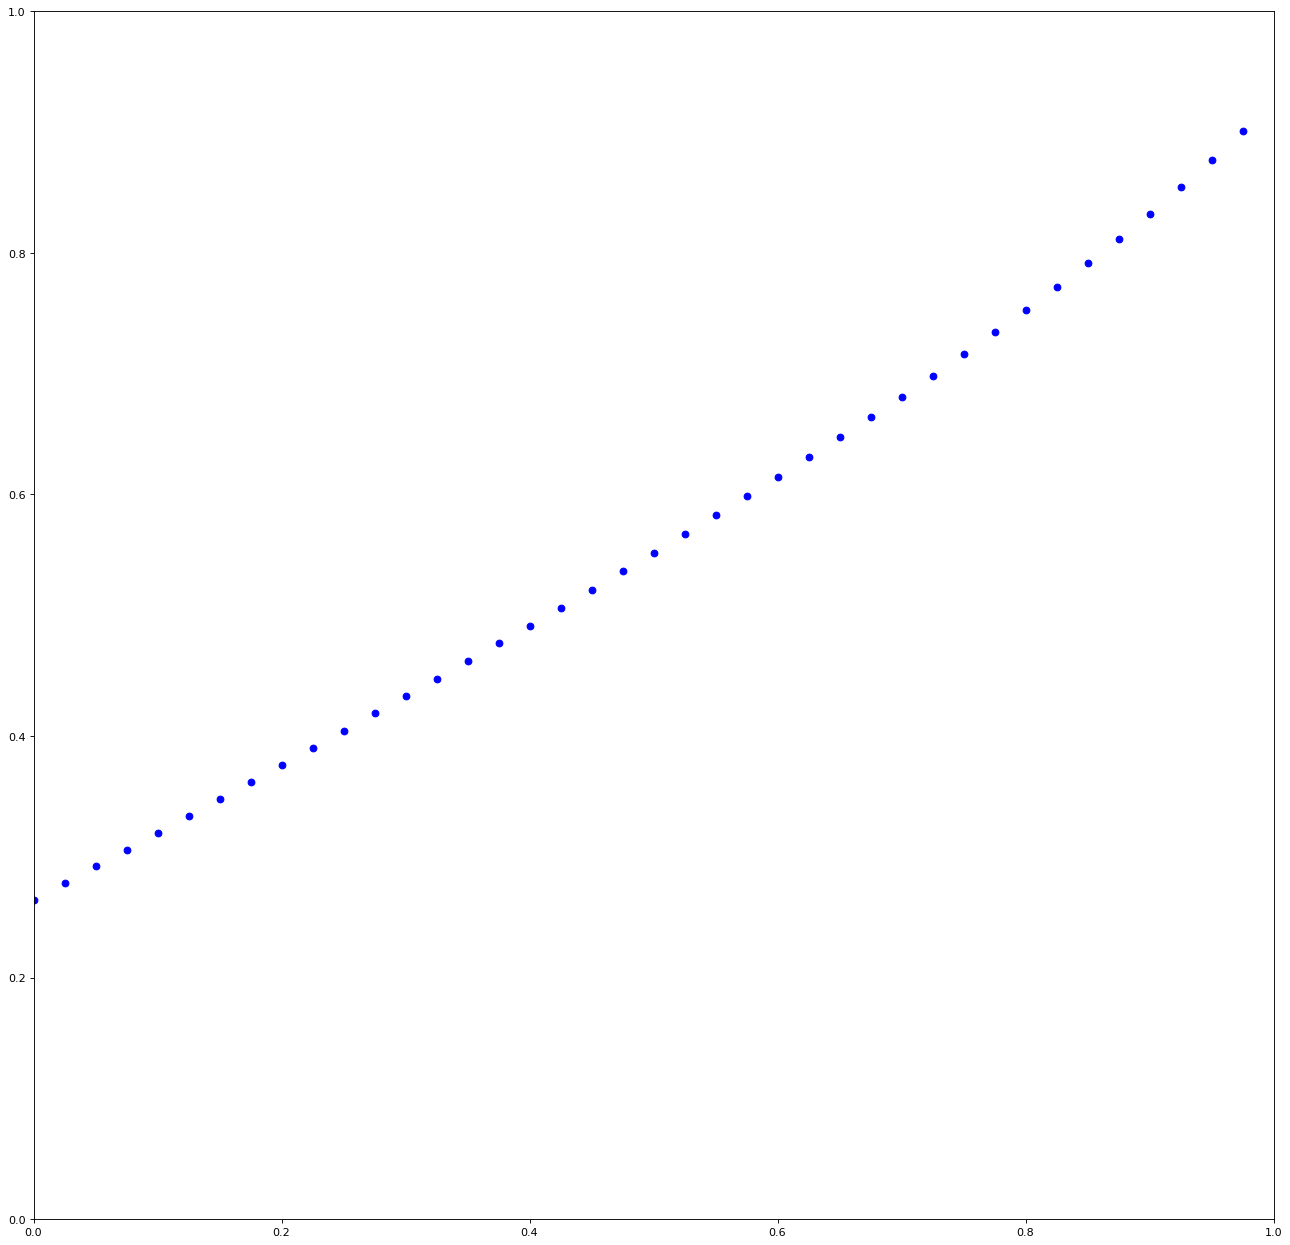

In [34]:
#this numpy move lets us apply the correlation map element wise to a vector
corr_map_vec = np.vectorize(corr_map, excluded=['sigmaW', 'sigmaB', 'dropout'])
def corr_map_plot(sigmaW, sigmaB, dropout, steps = 0.025, save = False, name = "untitled"):
    figure(figsize=(20, 20), dpi=80)
    x = np.arange(0, 1, steps)
    y = corr_map_vec(sigmaW, sigmaB, dropout, x)
    plt.plot (x, y, 'bo')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    if save == True:
        plt.savefig(name)
    plt.show()

corr_map_plot(2, 1, 0.9)

In [72]:
def find_fix_points_corr(sigmaW, sigmaB, dropout, start_val = 0.5):
    def fixed_point(f, guess, epsilon=10**(-5), n=100):
        itr=0
        test=f(guess)
        try:
            if (abs(test-guess)<epsilon):
                return(test)
        except:
            print(test, guess)


        while ((n>itr) and (abs(test-guess)>=epsilon)):
            itr+=1
            guess = test
            test = f(test)

            try:
                if ((abs(test-guess))<epsilon):
                  return(test)
            except:
                print(guess)

        return test

    def corr_map_alt(corr_prev_param):
        return corr_map(sigmaW, sigmaB, dropout, corr_prev_param)

    #return optimize.fixed_point(corr_map_alt, [0.5])[0]
    return fixed_point(corr_map_alt, start_val, epsilon=10**(-5), n=1000)

In [99]:
def deriv_at_fix_point(sigmaW, sigmaB, dropout):
    fix_point = find_fix_points_corr(sigmaW, sigmaB, dropout, start_val = 0.99)
    if round(fix_point, 3) != round(find_fix_points_corr(sigmaW, sigmaB, dropout, start_val = 0.3), 3):
        print("different fix points!")

    def corr_map_alt(corr_prev_param):
        return corr_map(sigmaW, sigmaB, dropout, corr_prev_param)

    return derivative(corr_map_alt, fix_point, 0.01)


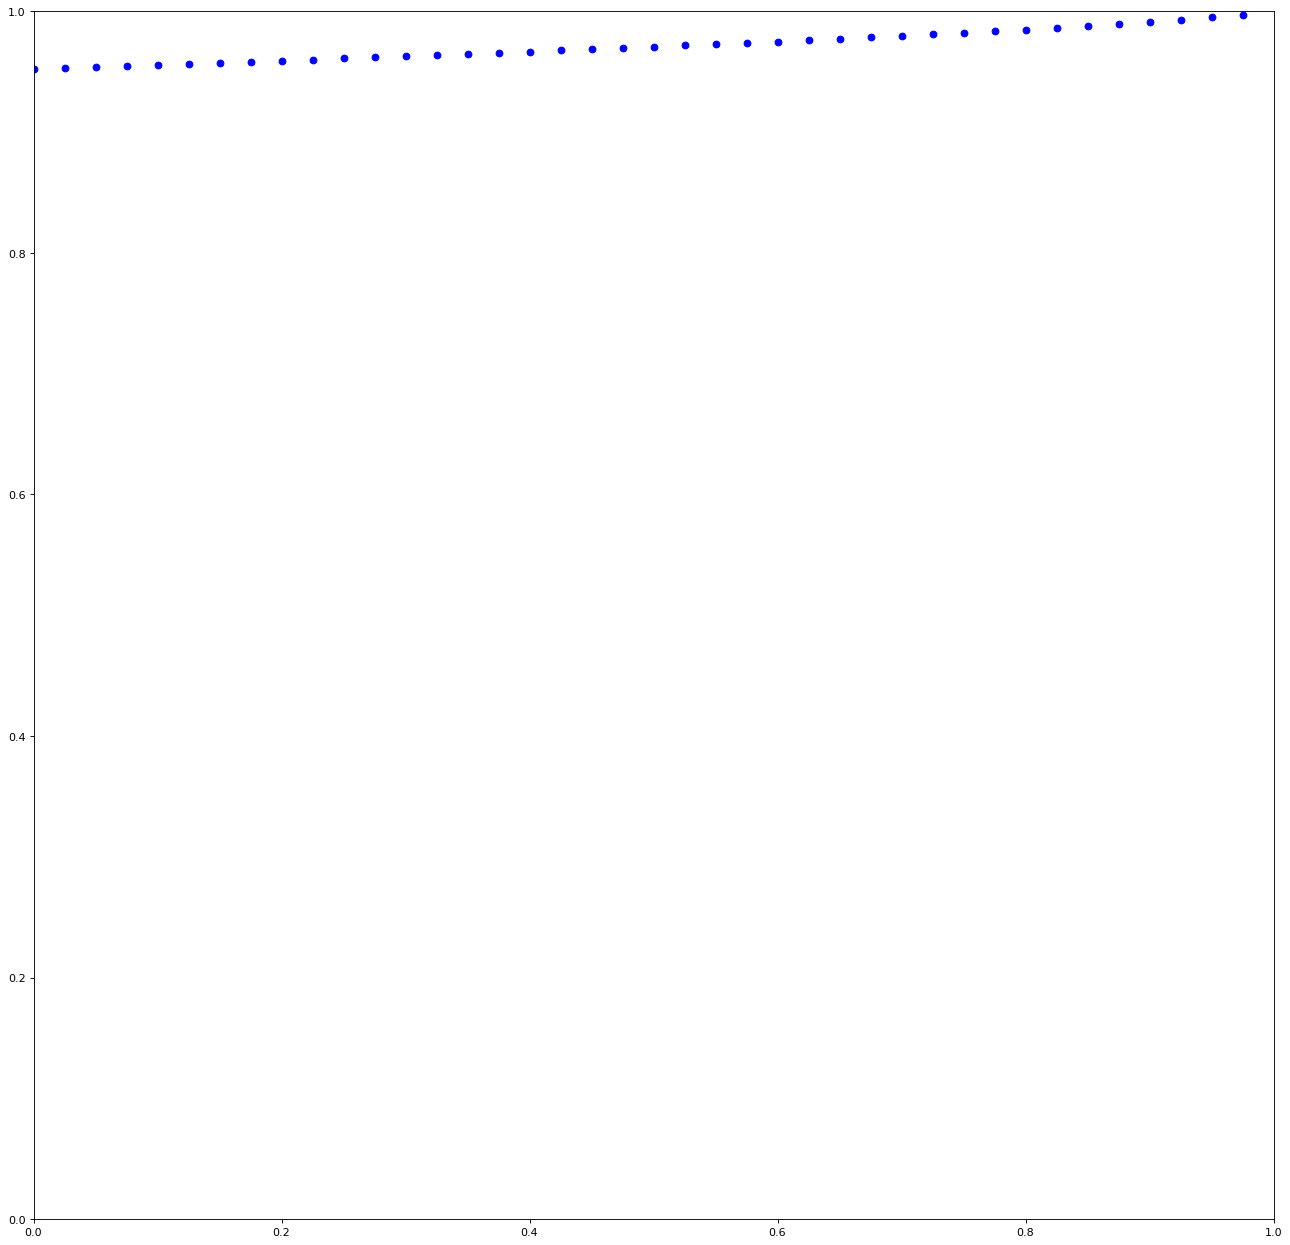

In [113]:
corr_map_plot(1, 4, 1)

In [114]:
find_fix_points_corr(1, 4, 1, start_val = 0.99)

0.999999999999992

In [109]:
corr_map(1, 1, 1, 1)

1.0000000000000633

In [101]:
deriv_at_fix_point(2, 1, 1)

0.9233719242293326

In [102]:
print("hello")

hello
